In [1]:
import sys
import os
import re
import logging
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")
import pint
import pint_xarray
from pint import application_registry as ureg
import cf_xarray.units
from collections import defaultdict
from intake import open_esm_datastore
from ruamel.yaml import YAML
import xarray as xr
from dask.distributed import Client

In [2]:
from matplotlib import pyplot as plt
client = Client(threads_per_worker=1)
client

INFO: State start
INFO: Found stale lock file and directory '/jobfs/129198285.gadi-pbs/dask-scratch-space/scheduler-k66ruzmc', purging
INFO:   Scheduler at:     tcp://127.0.0.1:41845
INFO:   dashboard at:         /proxy/8787/status
INFO: Registering Worker plugin shuffle
INFO:         Start Nanny at: 'tcp://127.0.0.1:42619'
INFO:         Start Nanny at: 'tcp://127.0.0.1:38003'
INFO:         Start Nanny at: 'tcp://127.0.0.1:44099'
INFO:         Start Nanny at: 'tcp://127.0.0.1:42147'
INFO:         Start Nanny at: 'tcp://127.0.0.1:35065'
INFO:         Start Nanny at: 'tcp://127.0.0.1:37281'
INFO:         Start Nanny at: 'tcp://127.0.0.1:38279'
INFO:         Start Nanny at: 'tcp://127.0.0.1:33003'
INFO:         Start Nanny at: 'tcp://127.0.0.1:43003'
INFO:         Start Nanny at: 'tcp://127.0.0.1:34171'
INFO:         Start Nanny at: 'tcp://127.0.0.1:45715'
INFO:         Start Nanny at: 'tcp://127.0.0.1:38419'
INFO:         Start Nanny at: 'tcp://127.0.0.1:35655'
INFO:         Start Nanny 

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 14
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41845,Workers: 14
Dashboard: /proxy/8787/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:42777,Total threads: 1
Dashboard: /proxy/35015/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:42619,


In [3]:
ryaml = YAML()
ryaml.preserve_quotes = True

In [4]:
def read_ryaml(yaml_path):
    """ Read yaml file and preserve comments"""
    with open(yaml_path, "r") as f:
        return ryaml.load(f)

In [5]:
expts_manager_path = '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager'
yamlfile_path = os.path.join(expts_manager_path, 'Expts_manager-025deg-75-layers.yaml')

In [6]:
def organise_input_info(MOM_dirs, MOM_names, MOM_full_paths):
    datastore_tot = []
    MOM_dirs_path_tot = []
    intake_esm_ds = 'intake_esm_ds.json'
    for i,j,k in zip(MOM_dirs,MOM_names,MOM_full_paths):
        archive_path = os.path.join(f"{output_expt_path}",f"{i}","archive")
        datastore_path = os.path.join(f"{archive_path}",intake_esm_ds)
        if os.path.isfile(datastore_path):
            datastore = open_esm_datastore(datastore_path,columns_with_iterables=["variable"])
            datastore_tot.append(datastore)
            MOM_dirs_path_tot.append(f"{k}")
    return datastore_tot, MOM_dirs_path_tot

In [7]:
yaml_input = read_ryaml(yamlfile_path)
test_rel_path = yaml_input['test_path']
output_expt_path = os.path.join(expts_manager_path, test_rel_path)

MOM_dirs = [
    yaml_input['base_dir_name'], # directory names
    yaml_input['namelists']['cross_block1']['cross_block1_dirs'][0], # directory names
]
MOM_names = ['KPP_ref', 'ePBL_OM5'] # can be user-defined names in this script
MOM_full_paths= [os.path.join(expts_manager_path, test_rel_path, MOM_dir) for MOM_dir in MOM_dirs]
datastore_tot, MOM_dirs_path_tot = organise_input_info(MOM_dirs, MOM_names, MOM_full_paths)

In [8]:
def sel_straits(strait):
    straits = {'Drake Passage': [ -69.9,  -69.9, -71.6, -51.0],
               'Lombok':        [-244.6, -243.9,  -8.6,  -8.6],
               'Ombai' :        [-235.0, -235.0,  -9.2,  -8.1],
               'Timor' :        [-235.9, -235.9, -11.9,  -9.9],
               'Denmark' :      [ -42.0,  -22.0,  65.8,  65.8],
               'Bering' :       [-172.0, -167.0,  65.8,  65.8],
               }
    xmin, xmax, ymin, ymax = straits[strait]
    return xmin, xmax, ymin, ymax

def trans_through_straits(trans, var, strait, xmin, xmax, ymin, ymax):
    rho0 = 1036*ureg.kilogram / ureg.meter**3

    if ymax >= 65:
        logging.info("North of 65N the tripolar grid geometry brings complications and .sum(\'longitude\') is wrong!")
    logging.info(f'Calculating {strait}')

    if xmin==xmax:
        if var == 'umo':
            transport = (trans/rho0).cf.sel(longitude=xmin, method="nearest").cf.sel(latitude=slice(ymin, ymax)).cf.sum({'vertical', 'latitude'})
            transport.attrs['long_name'] = 'zonal transport'
    elif ymin==ymax:
        if var == 'vmo':
            transport = (trans/rho0).cf.sel(longitude=slice(xmin, xmax)).cf.sel(latitude=ymin, method="nearest").cf.sum({'vertical', 'longitude'})
            transport.attrs['long_name'] = 'meridional transport'
    else:
            raise ValueError('Transports are computed only along lines of either constant latitude or constant longitude')

    transport = transport.pint.to('sverdrups')
    transport = transport.compute()

    return transport

In [10]:
xarray_combine_by_coords_kwargs=dict(
    compat="override",
    data_vars="minimal",
    coords="minimal"
)

0


INFO: Calculating Drake Passage


1


INFO: Calculating Drake Passage


0


INFO: Calculating Ombai


1


INFO: Calculating Ombai


0


INFO: Calculating Timor


1


INFO: Calculating Timor


0


INFO: Calculating Lombok


1


INFO: Calculating Lombok


0


INFO: North of 65N the tripolar grid geometry brings complications and .sum('longitude') is wrong!
INFO: Calculating Denmark


1


INFO: North of 65N the tripolar grid geometry brings complications and .sum('longitude') is wrong!
INFO: Calculating Denmark


0


INFO: North of 65N the tripolar grid geometry brings complications and .sum('longitude') is wrong!
INFO: Calculating Bering


1


INFO: North of 65N the tripolar grid geometry brings complications and .sum('longitude') is wrong!
INFO: Calculating Bering


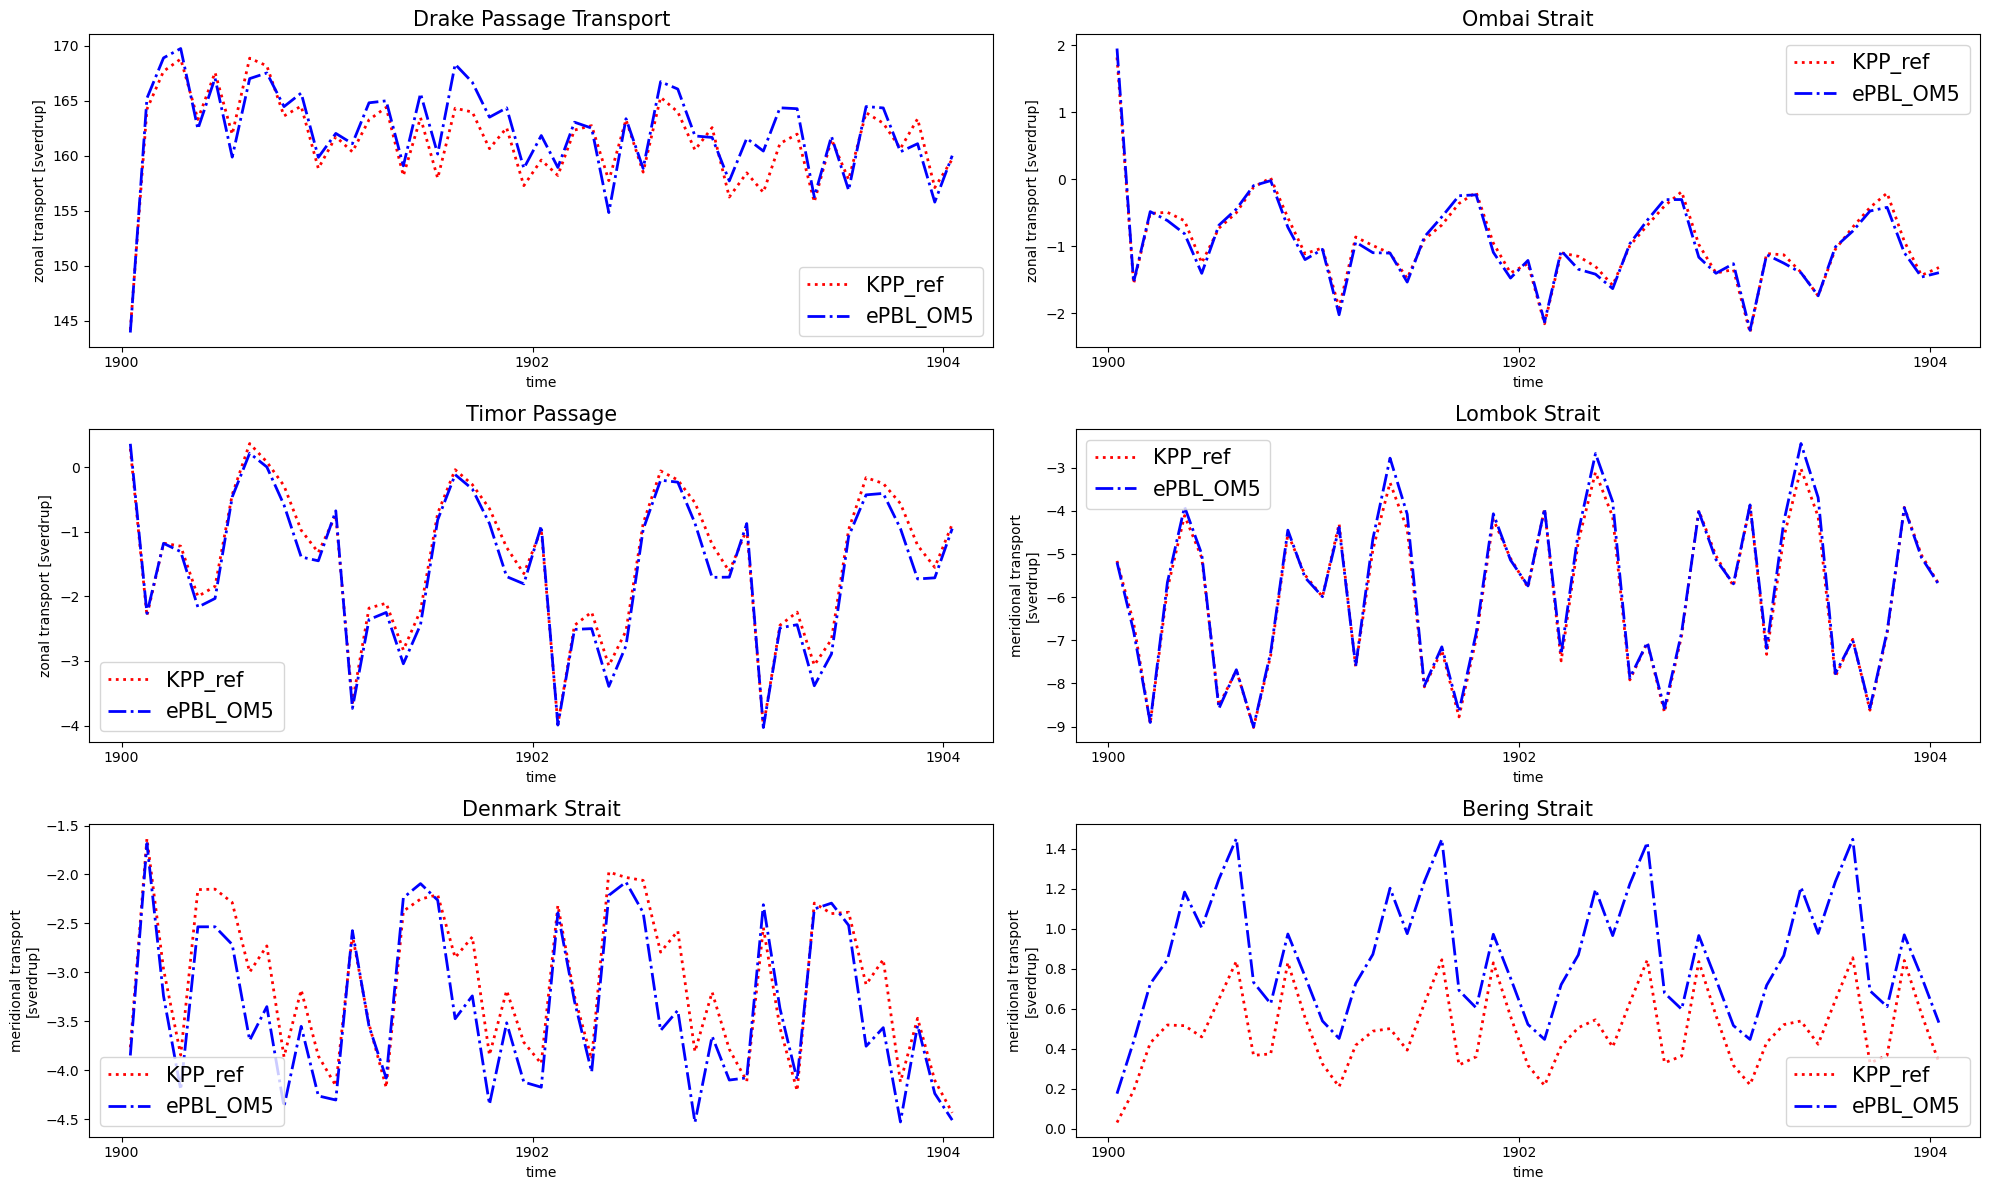

CPU times: user 37.7 s, sys: 1.68 s, total: 39.4 s
Wall time: 45.6 s


In [12]:
%%time

line_color = ['red','blue','pink','silver','lime','blue','red','pink','black','green']
line_style = [':','-.','-','-.',':','-.']
line_width = [2,2]
line_marker = None
markersize = None
plots_config = [
            {'var':'umo',
             'indices': [0,1],
             'title': 'Drake Passage Transport',
             'strait': 'Drake Passage',
            },
            {'var':'umo',
             'indices': [0,1],
             'title': 'Ombai Strait',
             'strait': 'Ombai',
            },
            {'var':'umo',
             'indices': [0,1],
             'title': 'Timor Passage',
             'strait': 'Timor',
            },
            {'var':'vmo',
             'indices': [0,1],
             'title': 'Lombok Strait',
             'strait': 'Lombok',
            },
            {'var':'vmo',
             'indices': [0,1],
             'title': 'Denmark Strait',
             'strait': 'Denmark',
            },
            {'var':'vmo',
             'indices': [0,1],
             'title': 'Bering Strait',
             'strait': 'Bering',
            },
]
time_range = ['1900-01-01', '1904-02-01']

indices = []
for config in plots_config:
    indices.append(config.get('indices', list(range(len(datastore_tot)))))

num_plots = len(plots_config)
ncols = 2
figsize = (20,12)
if num_plots>1:
    nrows = (num_plots + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten() if (nrows * ncols > 1) else [axes]
else:
    fig, ax = plt.subplots(figsize=figsize)

for plot_indx, _subplot in enumerate(plots_config):
    line_style = ['-'] * len(indices[plot_indx]) if line_style is None else line_style
    line_color = ['k'] * len(indices[plot_indx]) if line_color is None else line_color
    line_marker = [''] * len(indices[plot_indx]) if line_marker is None else line_marker
    line_width = [5] * len(indices[plot_indx]) if line_width is None else line_width
    markersize = [0] * len(indices[plot_indx]) if markersize is None else markersize

    var        = _subplot.get('var', None)
    strait     = _subplot.get('strait', None)
    line_title = _subplot.get('title', None)

    if num_plots>1:
        ax = axes[plot_indx]
        
    for tmp_indx, i in enumerate(indices[plot_indx]):
        dataset = datastore_tot[i].search(frequency='1mon',
                       variable=var,
                       ).to_dask(xarray_combine_by_coords_kwargs=xarray_combine_by_coords_kwargs)
        dataset = dataset.sel(time=slice(time_range[0],time_range[1])).pint.quantify()
        xmin, xmax, ymin, ymax = sel_straits(strait)
        dataset_dict = trans_through_straits(dataset[var], var, strait, xmin, xmax, ymin, ymax)
        dataset_dict.plot(ax=ax,
                       linestyle=line_style[i % len(line_style)],
                       color=line_color[i % len(line_color)],
                       marker=line_marker[i % len(line_marker)],
                       markersize=markersize[i % len(markersize)],
                       linewidth=line_width[i % len(line_width)],
                       label=f"{MOM_names[i]}")
        ax.set_title(line_title, fontsize=15)
        ax.legend(loc='best', fontsize=15)
plt.tight_layout()
plt.show()